# Dask bag

Dask proposes "big data" collections with a small set of high-level primitives like `map`, `filter`, `groupby`, and `join`.  With these common patterns we can often handle computations that are more complex than map, but are still structured.

- Dask-bag excels in processing data that can be represented as a sequence of arbitrary inputs ("messy" data)
- When you encounter a set of data with a format that does not enforce strict structure and datatypes.

**Related Documentation**

*  [Bag Documenation](http://dask.pydata.org/en/latest/bag.html)
*  [Bag API](http://dask.pydata.org/en/latest/bag-api.html)

In [1]:
data = list(range(1,9))
data

[1, 2, 3, 4, 5, 6, 7, 8]

In [2]:
import dask.bag as db

b = db.from_sequence(data)

In [3]:
b.compute()  # Gather results back to local process

[1, 2, 3, 4, 5, 6, 7, 8]

In [4]:
b.map(lambda x : x//2).compute() # compute length of each element and collect results

[0, 1, 1, 2, 2, 3, 3, 4]

In [5]:
from time import sleep

def slow_half( x):
    sleep(1)
    return x // 2

res = b.map(slow_half)
res

dask.bag<slow_half, npartitions=8>

In [6]:
%%time
res.compute()

CPU times: user 73.3 ms, sys: 165 ms, total: 238 ms
Wall time: 1.52 s


[0, 1, 1, 2, 2, 3, 3, 4]

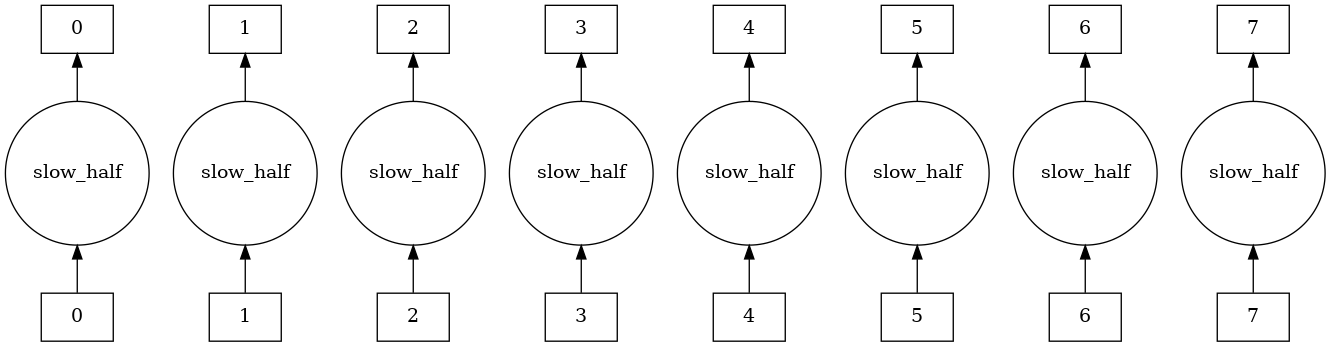

In [7]:
res.visualize()

In [8]:
b.topk

<bound method Bag.topk of dask.bag<from_sequence, npartitions=8>>

In [9]:
b.product(b).compute() # Cartesian product of each pair 
# of elements in two sequences (or the same sequence in this case)

[(1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 5),
 (5, 6),
 (5, 7),
 (5, 8),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 6),
 (6, 7),
 (6, 8),
 (7, 1),
 (7, 2),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6),
 (7, 7),
 (7, 8),
 (8, 1),
 (8, 2),
 (8, 3),
 (8, 4),
 (8, 5),
 (8, 6),
 (8, 7),
 (8, 8)]

Chain operations to construct more complex computations

In [10]:
(b.filter(lambda x: x % 2 > 0)
  .product(b)
  .filter( lambda v : v[0] % v[1] == 0 and v[0] != v[1])
  .compute())

[(3, 1), (5, 1), (7, 1)]

## Daily stock example

Let's use the bag interface to read the json files containing time series.

Each line is a JSON encoded dictionary with the following keys
- timestamp: Day.
- close: Stock value at the end of the day.
- high: Highest value.
- low: Lowest value.
- open: Opening price.

In [11]:
# preparing data
import os  # library to get directory and file paths
import tarfile # this module makes possible to read and write tar archives

def extract_data(name, where):
    datadir = os.path.join(where,name)
    if not os.path.exists(datadir):
       print("Extracting data...")
       tar_path = os.path.join(where, name+'.tgz')
       with tarfile.open(tar_path, mode='r:gz') as data:
          data.extractall(where)
            
extract_data('daily-stock','data') # this function call will extract json files

Extracting data...


In [12]:
%ls data/daily-stock/*.json

data/daily-stock/aet.json   data/daily-stock/hpq.json
data/daily-stock/afl.json   data/daily-stock/ibm.json
data/daily-stock/aig.json   data/daily-stock/jbl.json
data/daily-stock/al.json    data/daily-stock/jpm.json
data/daily-stock/amgn.json  data/daily-stock/luv.json
data/daily-stock/avy.json   data/daily-stock/met.json
data/daily-stock/b.json     data/daily-stock/pcg.json
data/daily-stock/bwa.json   data/daily-stock/tgt.json
data/daily-stock/ge.json    data/daily-stock/usb.json
data/daily-stock/hal.json   data/daily-stock/xom.json
data/daily-stock/hp.json


In [13]:
import dask.bag as db
import json
stocks = db.read_text('data/daily-stock/*.json')

In [14]:
stocks.npartitions

22

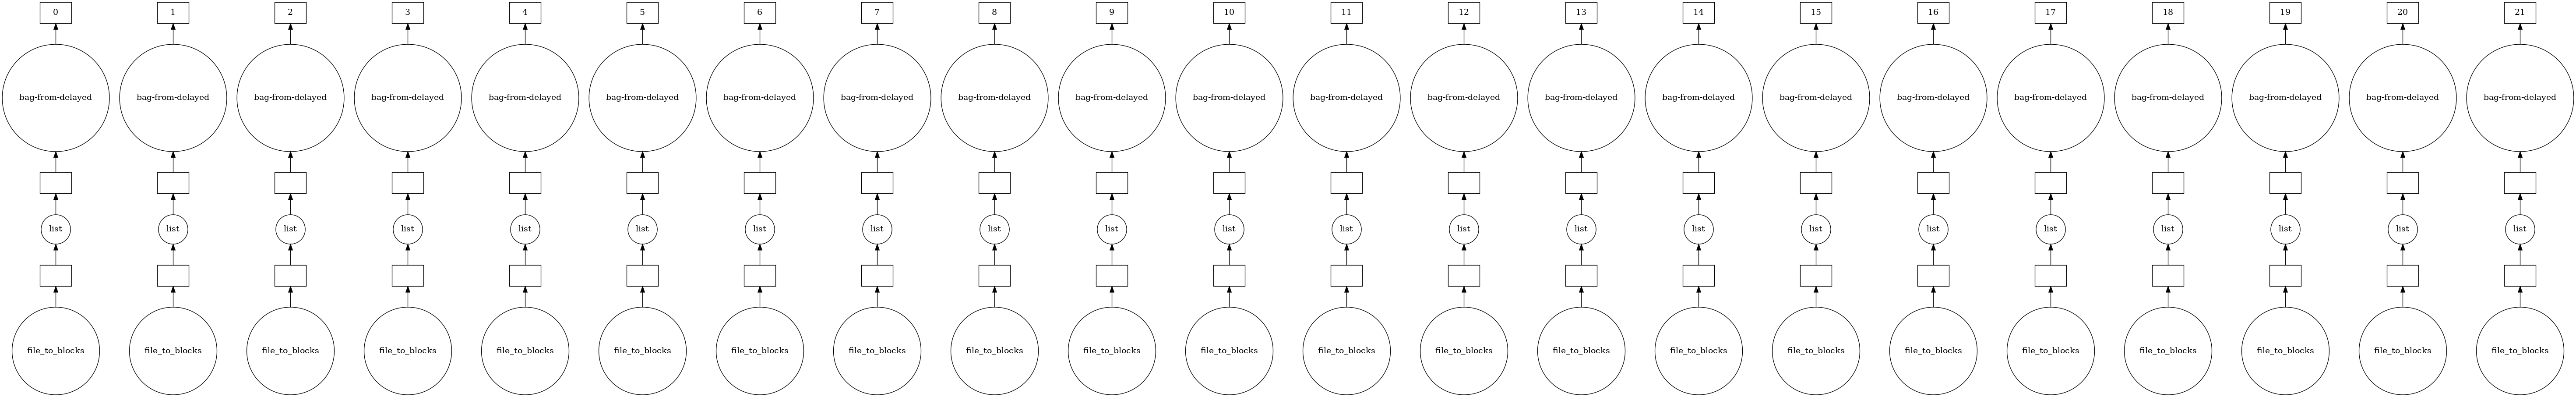

In [15]:
stocks.visualize()

In [16]:
import json
js = stocks.map(json.loads)

In [17]:
import os, sys
from glob import glob
import pandas as pd
import json

here = os.getcwd() # get the current directory
filenames = sorted(glob(os.path.join(here,'data', 'daily-stock', '*.json')))
filenames

['/home/navaro_p/big-data/notebooks/data/daily-stock/aet.json',
 '/home/navaro_p/big-data/notebooks/data/daily-stock/afl.json',
 '/home/navaro_p/big-data/notebooks/data/daily-stock/aig.json',
 '/home/navaro_p/big-data/notebooks/data/daily-stock/al.json',
 '/home/navaro_p/big-data/notebooks/data/daily-stock/amgn.json',
 '/home/navaro_p/big-data/notebooks/data/daily-stock/avy.json',
 '/home/navaro_p/big-data/notebooks/data/daily-stock/b.json',
 '/home/navaro_p/big-data/notebooks/data/daily-stock/bwa.json',
 '/home/navaro_p/big-data/notebooks/data/daily-stock/ge.json',
 '/home/navaro_p/big-data/notebooks/data/daily-stock/hal.json',
 '/home/navaro_p/big-data/notebooks/data/daily-stock/hp.json',
 '/home/navaro_p/big-data/notebooks/data/daily-stock/hpq.json',
 '/home/navaro_p/big-data/notebooks/data/daily-stock/ibm.json',
 '/home/navaro_p/big-data/notebooks/data/daily-stock/jbl.json',
 '/home/navaro_p/big-data/notebooks/data/daily-stock/jpm.json',
 '/home/navaro_p/big-data/notebooks/data/dai

In [18]:
%rm data/daily-stock/*.h5

rm: cannot remove 'data/daily-stock/*.h5': No such file or directory


In [21]:
%conda install tqdm

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.1
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/tljh/user/envs/big-data

  added / updated specs:
    - tqdm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    tqdm-4.49.0                |     pyh9f0ad1d_0          54 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          54 KB

The following NEW packages will be INSTALLED:

  tqdm               conda-forge/noarch::tqdm-4.49.0-pyh9f0ad1d_0



tqdm-4.49.0          | 54 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: failed

EnvironmentNotWritableError: The current user does not have write permi

In [19]:
from tqdm.notebook import tqdm
for fn in tqdm(filenames):
    with open(fn) as f:
        data = [json.loads(line) for line in f]
        
    df = pd.DataFrame(data)
    
    out_filename = fn[:-5] + '.h5'
    df.to_hdf(out_filename, '/data')

ModuleNotFoundError: No module named 'tqdm'

In [20]:
filenames = sorted(glob(os.path.join(here,'data', 'daily-stock', '*.h5')))
filenames

[]

### Serial version

In [31]:
%%time
series = {}
for fn in filenames:   # Simple map over filenames
    series[fn] = pd.read_hdf(fn)['close']

results = {}

for a in filenames:    # Doubly nested loop over the same collection
    for b in filenames:  
        if a != b:     # Filter out bad elements
            results[a, b] = series[a].corr(series[b])  # Apply function

((a, b), corr) = max(results.items(), key=lambda kv: kv[1])  # Reduction

CPU times: user 773 ms, sys: 63.2 ms, total: 836 ms
Wall time: 835 ms


In [32]:
a, b, corr

('/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/aet.h5',
 '/Users/navaro/PycharmProjects/big-data/notebooks/data/daily-stock/luv.h5',
 0.9413176064560879)

## Dask.bag methods

We can construct most of the above computation with the following dask.bag methods:

*  `collection.map(function)`: apply function to each element in collection
*  `collection.product(collection)`: Create new collection with every pair of inputs
*  `collection.filter(predicate)`: Keep only elements of colleciton that match the predicate function
*  `collection.max()`: Compute maximum element


In [33]:
%%time

import dask.bag as db

b = db.from_sequence(filenames)
series = b.map(lambda fn: pd.read_hdf(fn)['close'])

corr = (series.product(series)
              .filter(lambda ab: not (ab[0] == ab[1]).all())
              .map(lambda ab: ab[0].corr(ab[1])).max())

CPU times: user 4.92 ms, sys: 7.48 ms, total: 12.4 ms
Wall time: 12 ms


In [34]:
%%time

result = corr.compute()

CPU times: user 2.1 s, sys: 1.76 s, total: 3.86 s
Wall time: 6.41 s


In [35]:
result

0.9413176064560879

### Wordcount with Dask bag

In [36]:
import lorem

lorem.text()

'Quiquia porro amet non. Dolor eius dolore quaerat. Numquam modi quaerat quiquia porro tempora. Consectetur adipisci numquam dolore neque numquam. Labore ut labore dolore ut ut. Numquam est labore etincidunt numquam dolorem modi.\n\nQuiquia aliquam voluptatem sit ut. Sed velit sit ipsum etincidunt porro magnam. Dolore aliquam non velit numquam dolor quiquia. Aliquam quisquam adipisci sed adipisci dolor. Quaerat dolore dolorem adipisci neque quiquia consectetur. Sed labore dolore voluptatem neque est.\n\nEst aliquam labore etincidunt dolorem. Voluptatem ut ipsum porro velit neque sit voluptatem. Non dolor porro dolore ut. Voluptatem ipsum eius quaerat dolore amet porro consectetur. Dolor neque dolorem voluptatem labore neque porro porro. Dolor quiquia quiquia voluptatem non. Sit tempora dolor modi consectetur neque velit.'

In [37]:
import lorem

for i in range(20):
    with open(f"sample{i:02d}.txt","w") as f:
        f.write(lorem.text())

In [38]:
%ls *.txt

file_list.txt  sample02.txt   sample07.txt   sample12.txt   sample17.txt
output.txt     sample03.txt   sample08.txt   sample13.txt   sample18.txt
sample.txt     sample04.txt   sample09.txt   sample14.txt   sample19.txt
sample00.txt   sample05.txt   sample10.txt   sample15.txt   user.txt
sample01.txt   sample06.txt   sample11.txt   sample16.txt


In [39]:
import glob
glob.glob('sample*.txt')

['sample06.txt',
 'sample12.txt',
 'sample13.txt',
 'sample07.txt',
 'sample11.txt',
 'sample05.txt',
 'sample04.txt',
 'sample10.txt',
 'sample14.txt',
 'sample00.txt',
 'sample01.txt',
 'sample15.txt',
 'sample03.txt',
 'sample17.txt',
 'sample16.txt',
 'sample02.txt',
 'sample18.txt',
 'sample19.txt',
 'sample09.txt',
 'sample08.txt',
 'sample.txt']

In [41]:
import dask.bag as db
import glob
b = db.read_text(glob.glob('sample*.txt'))

wordcount = (b.str.replace(".","")  # remove dots
             .str.lower()           # lower text
             .str.strip()           # remove \n and trailing spaces
             .str.split()           # split into words
             .flatten()             # chain all words lists
             .frequencies()         # compute occurences
             .topk(10, lambda x: x[1])) # sort and return top 10 words


wordcount.compute() # Run all tasks and return result

[('dolor', 183),
 ('quisquam', 171),
 ('dolorem', 168),
 ('numquam', 168),
 ('aliquam', 161),
 ('amet', 159),
 ('etincidunt', 158),
 ('ipsum', 156),
 ('labore', 153),
 ('magnam', 152)]

## Genome example
We will use a Dask bag to calculate the frequencies of sequences of five bases, and then sort the sequences into descending order ranked by their frequency.

- First we will define some functions to split the bases into sequences of a certain size

### Exercise 9.1

- Implement a function `group_characters(line, n=5)` to group `n` characters together and return a iterator. `line` is a text line in genome.txt file.

```py
>>> line = "abcdefghijklmno"
>>> for seq in group_character(line, 5):
        print(seq)
        
"abcde"
"efghi"
"klmno"
```

    
- Implement `group_and_split(line)`
```py
>>> group_and_split('abcdefghijklmno')
['abcde', 'fghij', 'klmno']
```

- Use the dask bag to compute  the frequencies of sequences of five bases.

In [42]:
from string import ascii_lowercase as alphabet
alphabet

'abcdefghijklmnopqrstuvwxyz'

In [43]:
def reverse(text):
    k = len(text)
    while k > 0:
        k = k-1
        yield text[k]
    
reverse_alphabet = reverse(alphabet)
print(*reverse_alphabet)

z y x w v u t s r q p o n m l k j i h g f e d c b a


In [44]:
class Reverse:
    
    def __init__(self, data):
        self.data = data
        self.index = len(data)
        
    def __iter__(self):
        return self

    def __next__(self):
        self.index = self.index-1
        if self.index < 0:
            raise StopIteration
        else:
            return self.data[self.index]

In [45]:
class Fibonacci:
    
    def __init__(self, n):
        self.n = n
        self.f0 = 0
        self.f1 = 1
        
    def __iter__(self):
        return self
    
    def __next__(self):
        self.n = self.n - 1
        if self.n < 0:
            raise StopIteration
        else:
            self.f0, self.f1 = self.f1, self.f0 + self.f1
        return self.f1
    
print(*Fibonacci(7))

1 2 3 5 8 13 21


In [46]:
for c in Reverse(alphabet):
    print(c, end="")

zyxwvutsrqponmlkjihgfedcba

In [47]:
    
for c in reverse(alphabet):
    print(c, end="")

zyxwvutsrqponmlkjihgfedcba

In [49]:
def group_character( line, n=5):
    bases = ''
    for i, b in enumerate(line):
        bases += b
        if (i+1) % n == 0:
            yield bases
            bases = ''

In [50]:
line = "abcdefghijklmno"
for seq in group_character(line, 5):
    print(seq)

abcde
fghij
klmno


In [51]:
def group_and_split( line, n):
    return [seq for seq in group_character(line,n)]

In [52]:
%ls data

daily-stock/
daily-stock.tgz
genome.txt
irmar.csv
irmar.json
latinbooks.tgz
monthly.land.90S.90N.df_1901-2000mean.dat.txt
nucleotide-sample.txt
nycflights/
nycflights.tar.gz
people.json
philadelphia-crime-data-2015-ytd.csv


In [53]:
import os
from glob import glob

data_path = os.path.join("data")
with open(os.path.join(data_path,"genome.txt")) as g:
    data = g.read()
    for i in range(8):
        file = os.path.join(data_path,f"genome{i:02d}.txt")
        with open(file,"w") as f:
            f.write(data)

glob("data/genome0*.txt")

['data/genome01.txt',
 'data/genome00.txt',
 'data/genome02.txt',
 'data/genome03.txt',
 'data/genome07.txt',
 'data/genome06.txt',
 'data/genome04.txt',
 'data/genome05.txt']

In [55]:
from operator import itemgetter

import dask.bag as db

b = db.read_text("data/genome0*.txt")

result = (b.filter(lambda line: not line.startswith(">"))
  .map(lambda line: line.strip())
  .map(lambda line : group_and_split(line,5))
  .flatten()
  .frequencies()
  .topk(10,lambda v : v[1]))

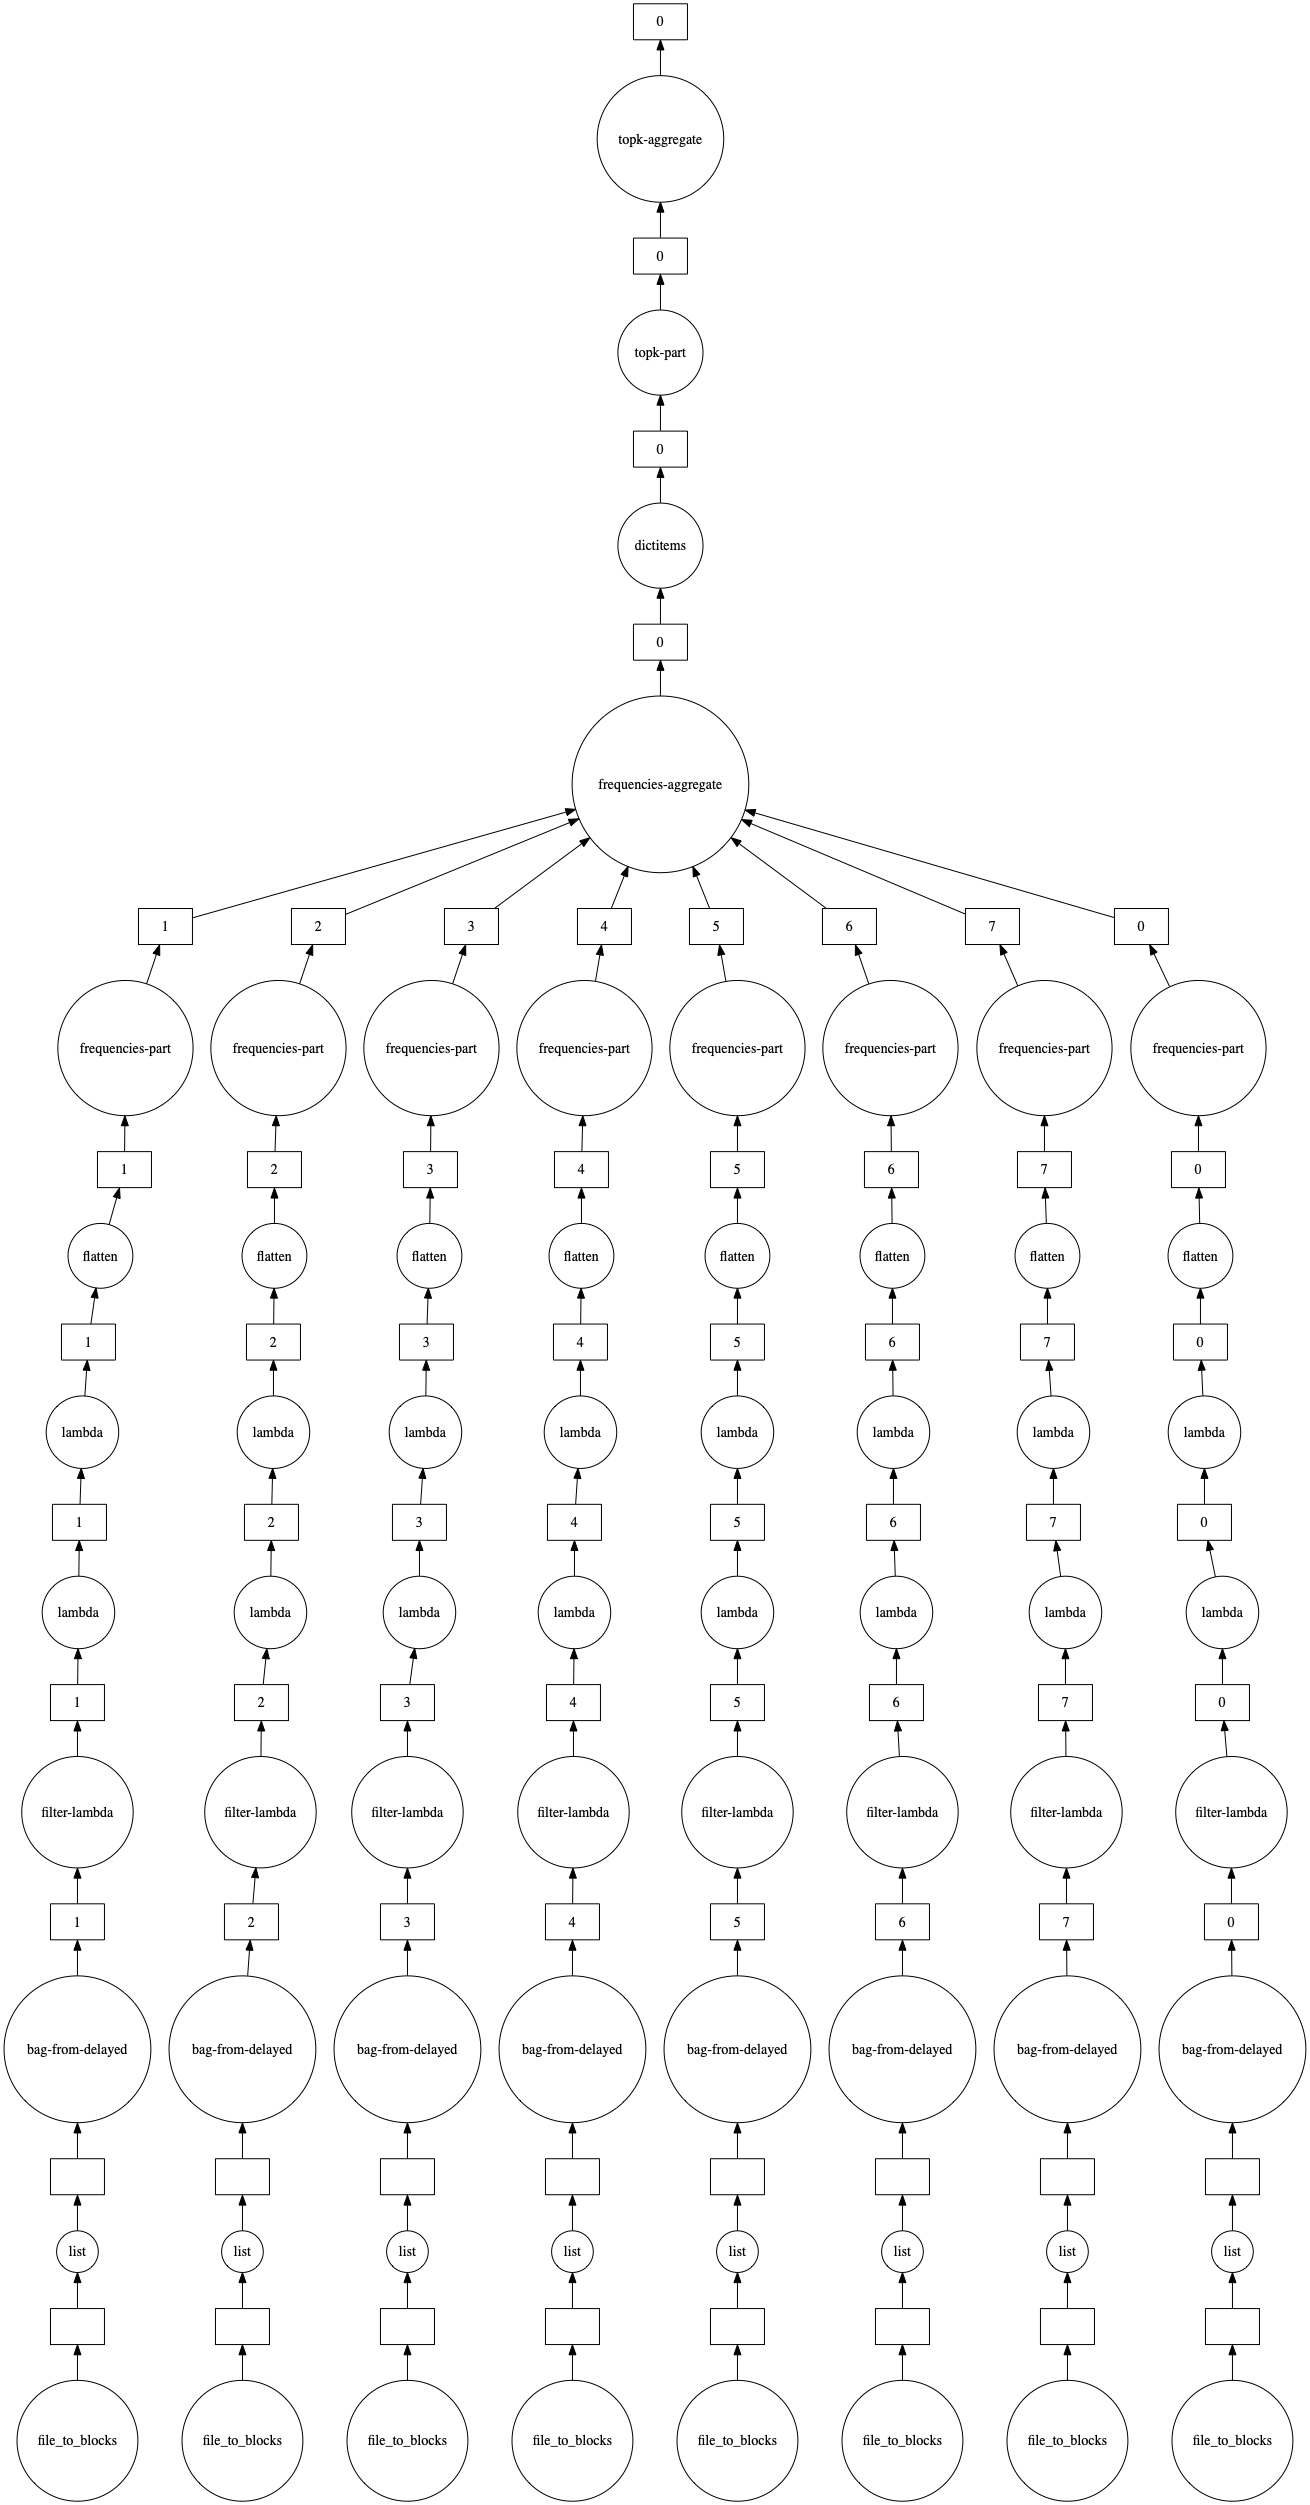

In [56]:
result.visualize()

In [57]:
result.compute()

[('CTGTG', 472),
 ('CCCAG', 440),
 ('CCTGG', 416),
 ('AAAAA', 392),
 ('TGCTG', 336),
 ('TGTGT', 328),
 ('CCACC', 312),
 ('GGCTG', 304),
 ('CACCA', 296),
 ('GGTGG', 296)]

### Exercise 9.2

The [FASTA](http://www.cbs.dtu.dk/services/NetGene2/fasta.php) file format is used to write several genome sequences.

- Create a function that can read a [FASTA file](../data/nucleotide-sample.txt) and compute the frequencies for n = 5 of a given sequence.

### Exercise 9.3

Write a program that uses the function implemented above to read several FASTA files stored in a Dask bag.

## Some remarks about bag

*  Higher level dask collections include functions for common patterns
*  Move data to collection, construct lazy computation, trigger at the end
*  Use Dask.bag (`product + map`) to handle nested for loop

Bags have the following known limitations

1.  Bag operations tend to be slower than array/dataframe computations in the
    same way that Python tends to be slower than NumPy/Pandas
2.  ``Bag.groupby`` is slow.  You should try to use ``Bag.foldby`` if possible.
    
3. Check the [API](http://dask.pydata.org/en/latest/bag-api.html) 

4. `dask.dataframe` can be faster than `dask.bag`.  But sometimes it is easier to load and clean messy data with a bag. We will see later how to transform a bag into a `dask.dataframe` with the [to_dataframe](http://dask.pydata.org/en/latest/bag-api.html#dask.bag.Bag.to_dataframe) method.